In [ ]:
# Configuration related preprocessing step before mounting the drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Processing**

In [ ]:
# Import Necessary Libraries
import os

# Set Directory path for Dataset
os.chdir("/content/drive/My Drive/My Projects/Face Mask Detection using CNN")
Dataset='Dataset'
Data_Dir=os.listdir(Dataset)  # used listdir function of the operating system pkg to list the directories contained inside the "Dataset" folder
print(Data_Dir)

['with mask', 'without mask']


In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical   # keras pckgs are used to convert text labels into One Hot Encoded form , dividing a data into train and test respectively
from sklearn.preprocessing import LabelBinarizer    # importing label binarizer from sklearn preprocessing pkg 
from sklearn.model_selection import train_test_split

img_rows, img_cols = 112, 112      # dimensions of a single img given as 112x112 pixel, th two variables holds these values of the images

images = []         # store all the images after performing gray scaling and resizing
labels = []         # contains labels corresponding to the classes of the image.eg., with mask or without mask

# nested for loops
for category in Data_Dir:   # picking up each class directory namely with mask and without mask fromm google drive location called as Data_Dir(which contains location of Dataset folder)
    folder_path = os.path.join(Dataset, category)     # joining dataset folder with each with each individual mask and wihout mask directory using separator '/'
    for img in os.listdir(folder_path):        # used to get the list of all image files in the specific directory
        img_path = os.path.join(folder_path, img)
        img=cv2.imread(img_path)       # reading that img using imread function

        # try exceot block for Error Handling
        try:
            #Coverting the image into gray scale
            grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            #resizing the gray scaled image into size 112x112 in order to keep size of the images consistent           
            resized_img=cv2.resize(grayscale_img,(img_rows, img_cols))
            images.append(resized_img)
            labels.append(category)
        # Exception Handling in case any error occurs
        except Exception as e:
            print('Exception:',e)

images=np.array(images)/255.0      # normalizing an image by dividing it by no 255
images=np.reshape(images,(images.shape[0],img_rows, img_cols,1))    # reshaping the img array without changing the data of image array  ,  we are reshapin because we wanr the images in a specific format

# Perform one hot encoding on the labels since the label are in textual form
lb = LabelBinarizer()              # creating object of label binarizer and naming it as "lb"
labels = lb.fit_transform(labels)  # using fit_transform method to apply label binarizer on each label
labels = to_categorical(labels)    # using to_categorical method to converts labels to One Hot Encoded form    
labels = np.array(labels)          # finally converting it into an array using numpy's array function
# these steps are required because deep learning models understand data in the form of vector/array


(train_X, test_X, train_y, test_y) = train_test_split(images, labels, test_size=0.25, 
                                                      random_state=0)                       # using train_test_split function to divide our image data into training and test dataset
# test data size here is 25% and rest 75% is training data


**Build Convolution Neural Network(CNN) Classification Model**

In [ ]:
# Import Necessary Keras Libraries,  keras is using tensorflow as an backend engine
# here I have imported CNN layers related libraries
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

# Every keras model is either built using sequential class(which represents a linear stack of layers) or the functional model class(which is more customisable)
# we are using a simpler sequential model, since the CNN will be the linear stack of layer

# Define model paramters
num_classes = 2     # 2 classes which aree with mask and without mask
batch_size = 32     # batchsize is a hyper parameter of gradient descent that controls the number of training samples to work through before the models internal parameters are updated

# Build CNN model using Sequential API
model=Sequential()

# First layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(64,(3,3),input_shape=(img_rows, img_cols, 1)))   # this layer is represented as conv 2d , 64 filters or feature detectors ,   kernel size is (3,3) which needs to be any odd number , numeric value 1 represents the channel type which is grayscale and hence kept as 1
model.add(Activation('relu'))      # activation is done using relu
model.add(MaxPooling2D(pool_size=(2,2)))   # maxpooling is used to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network,  maxpooling layer operates on each feature map independently

# Second layer group containing Convolution, Relu and MaxPooling layers
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Dropout Layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))  # used to reduce the overfitting problem in neural network

# Softmax Classifier
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))  # used for multiclass classification problem

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

**Plot the Model**

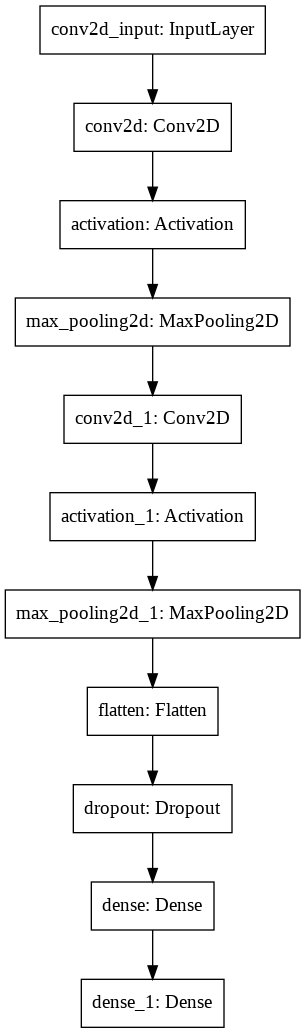

In [ ]:
# Plot the model using plot_model library
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='face_mask_detection_architecture.png')

**Train the Model**

In [ ]:
from keras.optimizers import Adam

epochs = 50

model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

fitted_model = model.fit(
    train_X,
    train_y,
    epochs = epochs,
    validation_split=0.25)

Epoch 1/50
25/25 [==============================] - 8s 45ms/step - loss: 1.1054 - accuracy: 0.4743 - val_loss: 0.6814 - val_accuracy: 0.6808
Epoch 2/50
25/25 [==============================] - 1s 25ms/step - loss: 0.6723 - accuracy: 0.6139 - val_loss: 0.6447 - val_accuracy: 0.6000
Epoch 3/50
25/25 [==============================] - 1s 25ms/step - loss: 0.6290 - accuracy: 0.6237 - val_loss: 0.5342 - val_accuracy: 0.7077
Epoch 4/50
25/25 [==============================] - 1s 25ms/step - loss: 0.5328 - accuracy: 0.7246 - val_loss: 0.3663 - val_accuracy: 0.8308
Epoch 5/50
25/25 [==============================] - 1s 26ms/step - loss: 0.3578 - accuracy: 0.8544 - val_loss: 0.2576 - val_accuracy: 0.9346
Epoch 6/50
25/25 [==============================] - 1s 25ms/step - loss: 0.2932 - accuracy: 0.8880 - val_loss: 0.2793 - val_accuracy: 0.8769
Epoch 7/50
25/25 [==============================] - 1s 25ms/step - loss: 0.2316 - accuracy: 0.9120 - val_loss: 0.1985 - val_accuracy: 0.9192
Epoch 8/50
25

**Plot the Training Loss and Accuracy**

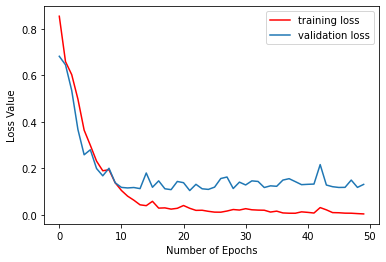

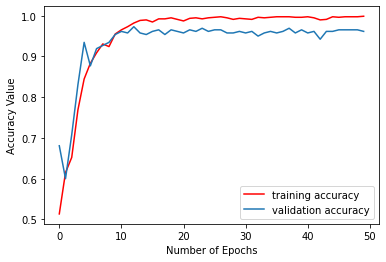

In [ ]:
from matplotlib import pyplot as plt
# Plot Training and Validation Loss
plt.plot(fitted_model.history['loss'],'r',label='training loss')
plt.plot(fitted_model.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

**Save or Serialize the Model**

In [ ]:
# Save or Serialize the model with the name face_mask_detection_using_cnn
model.save('face_mask_detection_using_cnn.h5')